In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['koko-data', 'reducing-image-sizes-to-32x32', 'iwildcam-2019-fgvc6']


In [3]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [7]:
x_train = np.load('../input/koko-data/X_train.npy')
x_test = np.load('../input/koko-data/X_test.npy')
y_train = np.load('../input/koko-data/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [9]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

In [11]:
def create_Model():
    classifier=Sequential()
    classifier.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=x_train.shape[1:],activation='relu'))
    #classifier.add(Conv2D(64, (3, 3), activation='relu'))
    #classifier.add(ZeroPadding2D(padding=(1,1)))
    #classifier.add(BatchNormalization())
    #classifier.add(PReLU())
    classifier.add(Conv2D(32, (3, 3)))
    classifier.add(Activation('relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(64, (3, 3), padding='same'))
    classifier.add(Activation('relu'))
    classifier.add(Conv2D(64, (3, 3)))
    classifier.add(Activation('relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Flatten())
    classifier.add(Dense(512))
    classifier.add(Activation('relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(14))
    classifier.add(Activation('softmax'))
    return classifier
model=create_Model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [12]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=7,
    callbacks=[checkpoint, f1_metrics],
    validation_split=0.1
)

Instructions for updating:
Use tf.cast instead.
Train on 176669 samples, validate on 19630 samples
Epoch 1/7
176669/176669 [==============================] - 684s 4ms/step - loss: 0.7107 - acc: 0.7789 - val_loss: 0.4987 - val_acc: 0.8403

Epoch 00001: val_acc improved from -inf to 0.84035, saving model to model.h5


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val_f1: 0.4947 — val_precision: 0.6020 — val_recall: 0.4711
Epoch 2/7
176669/176669 [==============================] - 681s 4ms/step - loss: 0.5111 - acc: 0.8343 - val_loss: 0.4120 - val_acc: 0.8640

Epoch 00002: val_acc improved from 0.84035 to 0.86403, saving model to model.h5
val_f1: 0.6313 — val_precision: 0.7207 — val_recall: 0.5964
Epoch 3/7
176669/176669 [==============================] - 677s 4ms/step - loss: 0.4533 - acc: 0.8517 - val_loss: 0.3673 - val_acc: 0.8788

Epoch 00003: val_acc improved from 0.86403 to 0.87876, saving model to model.h5
val_f1: 0.6997 — val_precision: 0.7436 — val_recall: 0.6875
Epoch 4/7
176669/176669 [==============================] - 680s 4ms/step - loss: 0.4165 - acc: 0.8622 - val_loss: 0.3460 - val_acc: 0.8835

Epoch 00004: val_acc improved from 0.87876 to 0.88349, saving model to model.h5
val_f1: 0.7158 — val_precision: 0.7629 — val_recall: 0.6972
Epoch 5/7
176669/176669 [==============================] - 680s 4ms/step - loss: 0.3924 - acc: 0.869

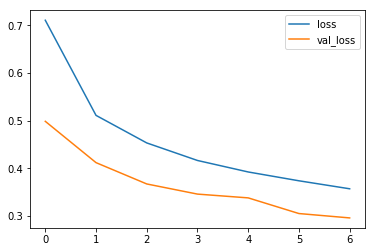

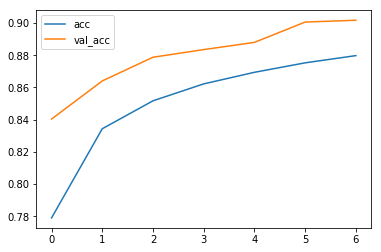

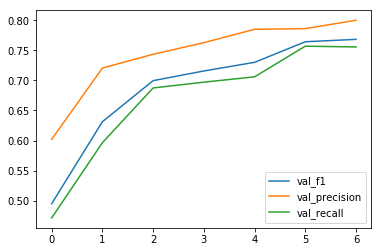

In [13]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

In [14]:
model.load_weights('model.h5')
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)

In [15]:
submission_df.to_csv('submission.csv',index=False)